# 보안 키, 토큰 불러오기 (from .env)

In [ ]:
!pip install -q python-dotenv

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()  # .env 파일의 내용을 읽어들임

PREDIBASE_API_KEY = os.getenv('PREDIBASE_API_KEY')
UPSTAGE_API_KEY = os.getenv('UPSTAGE_API_KEY')
WNB_KEY = os.getenv('WANDB_API_KEY')

# Langchain 셋업

In [2]:
!pip install -q langchain openai tiktoken chromadb

In [3]:
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.llms import OpenAI
from langchain.chains import RetrievalQA
from langchain.document_loaders import TextLoader, DirectoryLoader, PyMuPDFLoader

# RAG를 위한 데이터(문서) 불러오기

In [4]:
!pip install -q pymupdf

- 서울대학교 학내 응급환자 대응 메뉴얼 : https://health4u.snu.ac.kr/data/download/1_2.pdf

In [6]:
# Define the PDF loader
from IPython.display import Markdown

# pdf_loader = PyMuPDFLoader("./서울시, 전국 최초 _정신응급합동센터_ 운영중…정신전문가 24시간 현장 대응.pdf")

## TODO : 아래 pdf들에 대한 OCR이 이뤄져야 할 것 같음. (Tesseract, Upstage Document AI 등)

# pdf_loader = PyMuPDFLoader("./학내 결핵 및 감염성질환 관리 지침.pdf")
pdf_loader = PyMuPDFLoader("https://health4u.snu.ac.kr/data/download/1_2.pdf")

# Load data from the pdf
pages = pdf_loader.load()

# Observe number of pages loaded
print("Number of pages loaded: {} \n".format(len(pages)))

Markdown(pages[0].page_content) # page_content가 정상적으로 불러와지지 않음.

Number of pages loaded: 68 



## Asynchronous layout analysis (100p 이상은 async)
- https://developers.upstage.ai/docs/apis/layout-analysis/async#inference-request

In [ ]:
# # OCR request

# import requests
 
# api_key = "UPSTAGE_API_KEY"
# filename = "invoice.png"
 
# url = "https://api.upstage.ai/v1/document-ai/async/layout-analysis"
# headers = {"Authorization": f"Bearer {api_key}"}
# files = {"document": open(filename, "rb")}
# data = {"ocr": True}
# response = requests.post(url, headers=headers, files=files, data=data)
# print(response.json())

In [ ]:
# # OCR response
# import requests
 
# api_key = "UPSTAGE_API_KEY"
 
# url = "https://api.upstage.ai/v1/document-ai/requests/REQUEST_ID"
# headers = {"Authorization": f"Bearer {api_key}"}
# response = requests.get(url, headers=headers)
# print(response.json())



## Langchain으로 Layout Analysis


In [7]:
!pip install -q langchain_upstage

In [9]:
from langchain_upstage import UpstageLayoutAnalysisLoader
 
file_path = "snu_health4u.pdf" # 링크는 안됨

# For image files, set use_ocr to True to perform OCR inference on the document before layout detection.
loader = UpstageLayoutAnalysisLoader(file_path, split="page", api_key=UPSTAGE_API_KEY, use_ocr=True)
 
# For improved memory efficiency, consider using the lazy_load method to load documents page by page.
pages = loader.load()  # or loader.lazy_load()
 
for page in pages:
    print(page) # print the document content

page_content='<h1 id='0' style='font-size:20px'>서울대학교<br>학내 응급환자 대응 매뉴얼</h1> <h1 id='1' style='font-size:16px'>제2판</h1> <h1 id='2' style='font-size:18px'>학생 · 교직원용</h1>' metadata={'page': 1}
page_content='<h1 id='4' style='font-size:18px'>차례</h1> <p id='5' data-category='paragraph' style='font-size:14px'>1 학내 응급환자 신고 체계 5<br>2 응급환자 신고 요령 7<br>3 응급환자의 분류 8<br>4 응급 단계별 대처방안 9<br>5 정신과적 응급상황 분류 10<br>6 정신과적 응급 단계별 대처 방안 11<br>7 현장응급처치 14<br>1. 심정지 16<br>2. 기도폐쇄 19<br>3. 의식 소실 22<br>4. 뇌졸중이 의심될 때 24<br>5. 중독 25<br>6. 경련 27<br>7. 익수 사고 28<br>8. 척수손상 29<br>9. 쇼크 30<br>10. 둔상 32<br>11. 상처 33<br>12. 출혈 35<br>13. 코피 37</p>' metadata={'page': 2}
page_content='<p id='6' data-category='paragraph' style='font-size:14px'>14. 손가락 등 절단 38<br>15. 골절 ......... 39<br>16. 탈구 ·· ··· ·· 41<br>17. 염좌 ・・・・・・・・・・・・・ ・・・・・・・・ 42<br>18. 화상 " ...... 43<br>19. 감전(전기 화상) ······ 45<br>20. 화학물질에 의한 화상 .. ···· 46<br>21. 열사병 ・・・・・・・・・ ········ 47<br>22. 동상 ··· 48<br>23. 저체온증 49<br>24. 벌에 쏘였을 때 50<br>25. 곤충에 물렸을 때 51<br

In [10]:
# pages 내에 68페이지에 해당하는 OCR결과물이 저장됨
pages[0]
# metadata, page_content로 구성된 개별 결과물임.

Document(metadata={'page': 1}, page_content="<h1 id='0' style='font-size:20px'>서울대학교<br>학내 응급환자 대응 매뉴얼</h1> <h1 id='1' style='font-size:16px'>제2판</h1> <h1 id='2' style='font-size:18px'>학생 · 교직원용</h1>")

In [11]:
# OCR 결과물을 json으로 저장
import json

pages_list = [
    {"text": page.page_content, "metadata": page.metadata} for page in pages
]

with open("ocr_result.json", "w", encoding="utf-8") as file: 
    json.dump(pages_list, file, ensure_ascii=False, indent=4)

In [14]:
# JSON 파일에서 Document 리스트 불러오기
def load_documents_from_json(file_name):

    from langchain_core.documents.base import Document

    with open(file_name, "r", encoding="utf-8") as file:
        docs_list = json.load(file)
    return [
        Document(page_content=doc["text"], metadata=doc["metadata"]) for doc in docs_list
    ]


In [15]:
# 불러오기
load_pages = load_documents_from_json("./ocr_result.json")
for page in load_pages:
    print(page)

page_content='<h1 id='0' style='font-size:20px'>서울대학교<br>학내 응급환자 대응 매뉴얼</h1> <h1 id='1' style='font-size:16px'>제2판</h1> <h1 id='2' style='font-size:18px'>학생 · 교직원용</h1>' metadata={'page': 1}
page_content='<h1 id='4' style='font-size:18px'>차례</h1> <p id='5' data-category='paragraph' style='font-size:14px'>1 학내 응급환자 신고 체계 5<br>2 응급환자 신고 요령 7<br>3 응급환자의 분류 8<br>4 응급 단계별 대처방안 9<br>5 정신과적 응급상황 분류 10<br>6 정신과적 응급 단계별 대처 방안 11<br>7 현장응급처치 14<br>1. 심정지 16<br>2. 기도폐쇄 19<br>3. 의식 소실 22<br>4. 뇌졸중이 의심될 때 24<br>5. 중독 25<br>6. 경련 27<br>7. 익수 사고 28<br>8. 척수손상 29<br>9. 쇼크 30<br>10. 둔상 32<br>11. 상처 33<br>12. 출혈 35<br>13. 코피 37</p>' metadata={'page': 2}
page_content='<p id='6' data-category='paragraph' style='font-size:14px'>14. 손가락 등 절단 38<br>15. 골절 ......... 39<br>16. 탈구 ·· ··· ·· 41<br>17. 염좌 ・・・・・・・・・・・・・ ・・・・・・・・ 42<br>18. 화상 " ...... 43<br>19. 감전(전기 화상) ······ 45<br>20. 화학물질에 의한 화상 .. ···· 46<br>21. 열사병 ・・・・・・・・・ ········ 47<br>22. 동상 ··· 48<br>23. 저체온증 49<br>24. 벌에 쏘였을 때 50<br>25. 곤충에 물렸을 때 51<br

## WEB 기반으로 불러오기(필요 시)

In [ ]:
# ext_link = "https://www.msdmanuals.com/ko-kr/home"

# # Load documents from web
# from langchain.document_loaders import WebBaseLoader

# web_loader = WebBaseLoader([
#     ext_link,
#     "https://python.langchain.com/docs/get_started/introduction",   # LangChain Introduction
#     "https://python.langchain.com/docs/modules/data_connection/" # LangChain Retrieval
#     ]
# )

# data = web_loader.load()
# data

# Chunking

In [16]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Use the recursive character splitter
recur_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=60,
    separators=["\n\n", "\n", "\.", " ", ""]
)

# Perform the splits using the splitter
data_splits = recur_splitter.split_documents(pages)
print(data_splits)
print("Number of splits:", len(data_splits))

# Print a random chunk
import random
content = random.choice(data_splits).page_content
print("Content length:", len(content))
print(content)

[Document(metadata={'page': 1}, page_content="<h1 id='0' style='font-size:20px'>서울대학교<br>학내 응급환자 대응 매뉴얼</h1> <h1 id='1' style='font-size:16px'>제2판</h1> <h1 id='2' style='font-size:18px'>학생 · 교직원용</h1>"), Document(metadata={'page': 2}, page_content="<h1 id='4' style='font-size:18px'>차례</h1> <p id='5' data-category='paragraph' style='font-size:14px'>1 학내 응급환자 신고 체계 5<br>2 응급환자 신고 요령 7<br>3 응급환자의 분류 8<br>4 응급 단계별 대처방안 9<br>5 정신과적 응급상황 분류 10<br>6 정신과적 응급 단계별 대처 방안 11<br>7 현장응급처치 14<br>1. 심정지 16<br>2. 기도폐쇄 19<br>3. 의식 소실 22<br>4. 뇌졸중이 의심될 때 24<br>5. 중독 25<br>6. 경련 27<br>7. 익수 사고 28<br>8. 척수손상 29<br>9. 쇼크 30<br>10. 둔상 32<br>11. 상처 33<br>12. 출혈 35<br>13. 코피 37</p>"), Document(metadata={'page': 3}, page_content='<p id=\'6\' data-category=\'paragraph\' style=\'font-size:14px\'>14. 손가락 등 절단 38<br>15. 골절 ......... 39<br>16. 탈구 ·· ··· ·· 41<br>17. 염좌 ・・・・・・・・・・・・・ ・・・・・・・・ 42<br>18. 화상 " ...... 43<br>19. 감전(전기 화상) ······ 45<br>20. 화학물질에 의한 화상 .. ···· 46<br>21. 열사병 ・・・・・・・・・ ········ 47<br>22. 동상 ·

In [17]:
print(len(data_splits)) # After chunking

136


# Vector Store 구축

## Upstage의 Embedding 불러오기
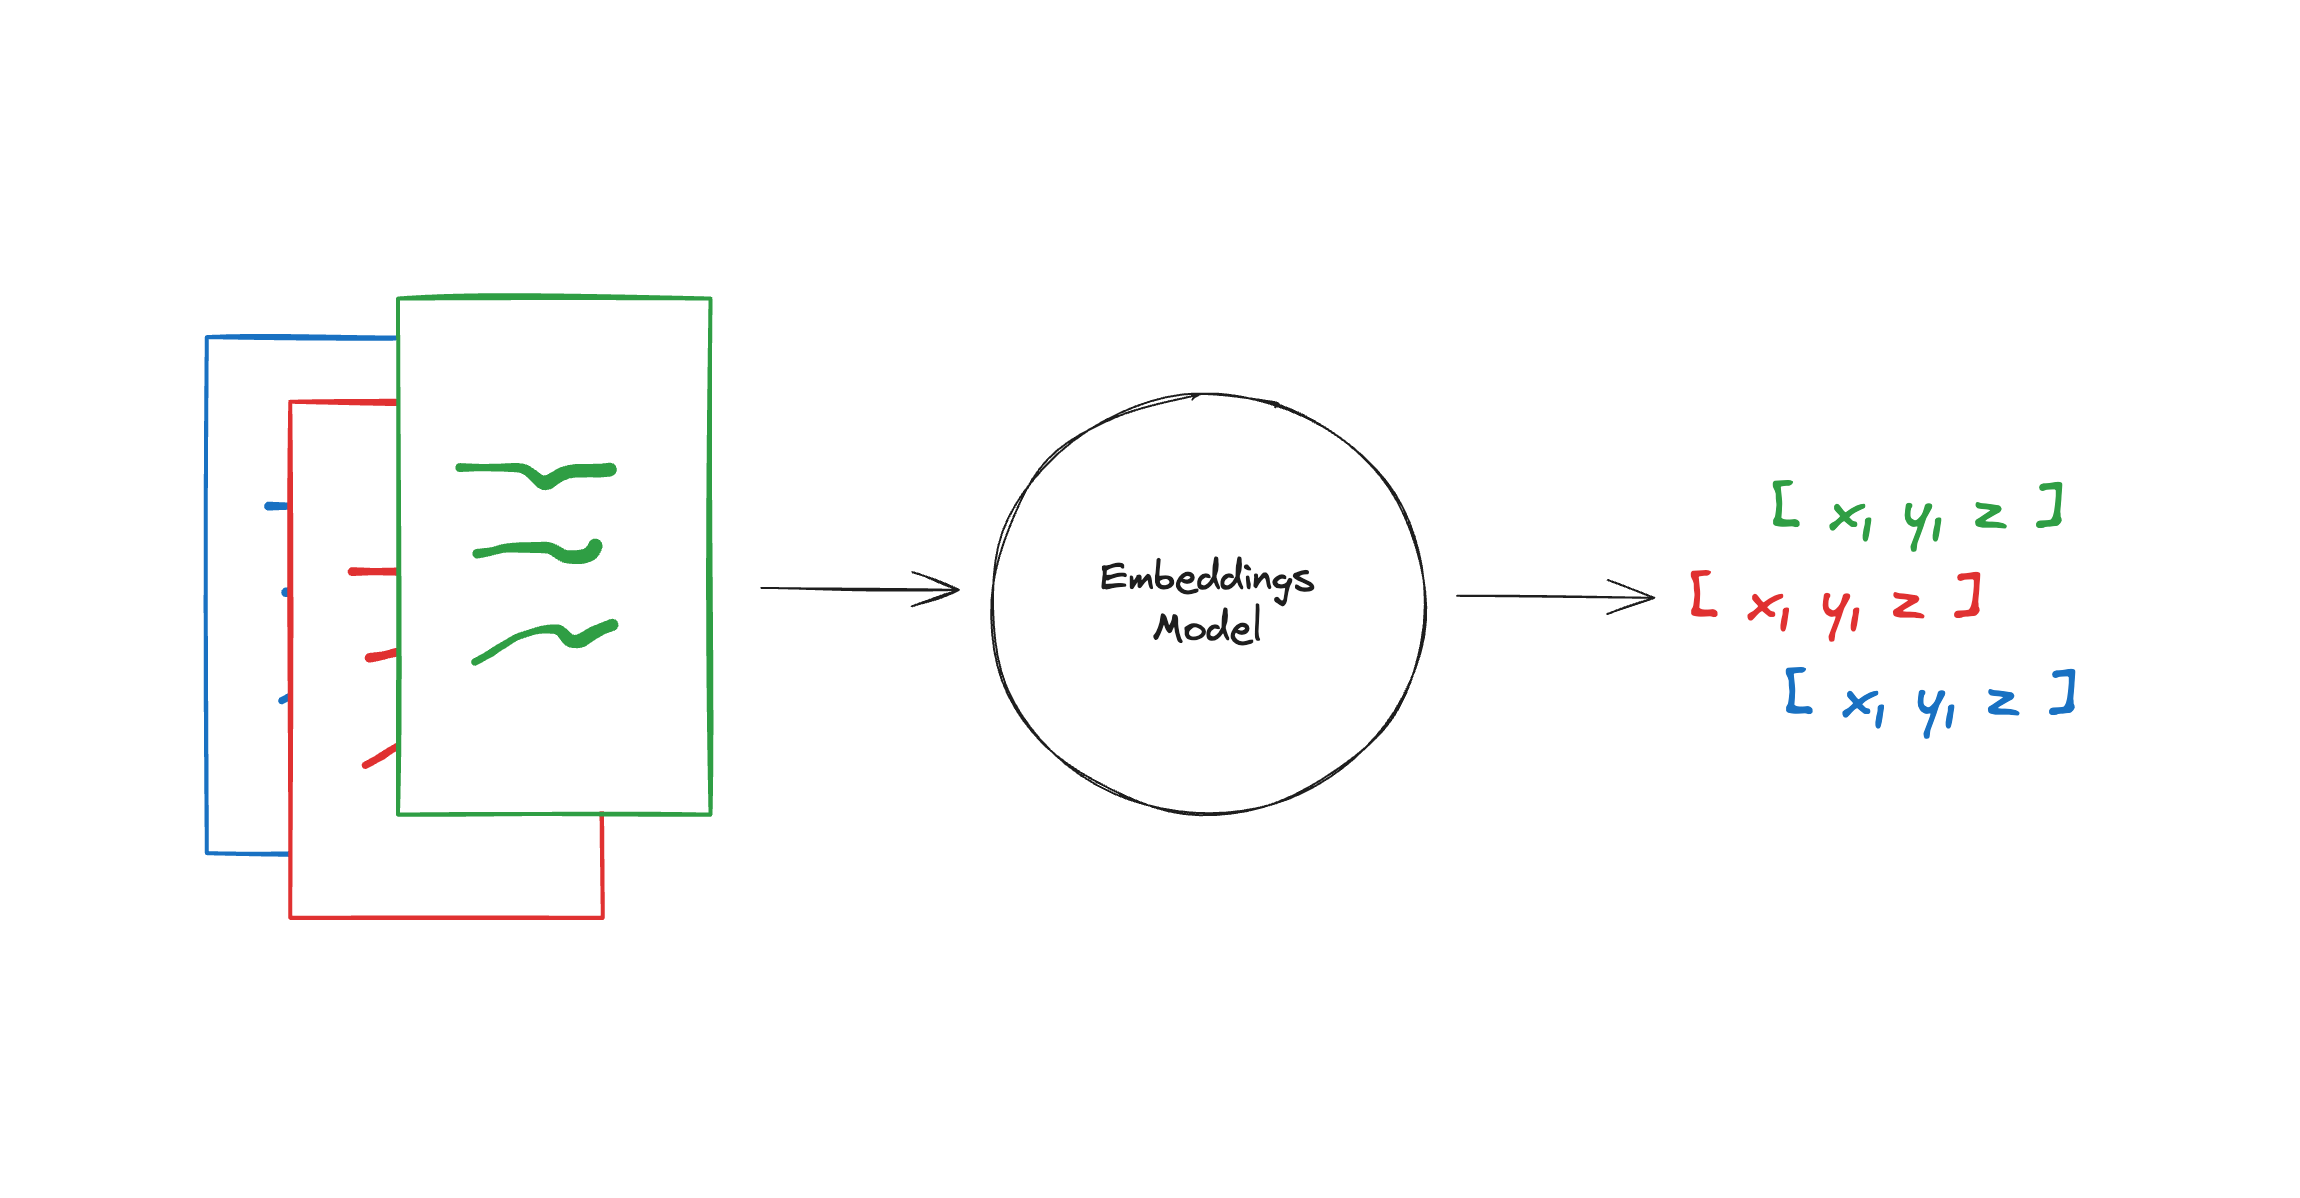
- Embedding을 통해서 텍스트 데이터를 벡터/수치화
- https://developers.upstage.ai/docs/apis/embeddings

In [18]:
from langchain_upstage import UpstageEmbeddings
 
embeddings = UpstageEmbeddings(
  api_key=UPSTAGE_API_KEY,
  model="solar-embedding-1-large"
)

# Test
doc_result = embeddings.embed_documents(
    ["SOLAR 10.7B: Scaling Large Language Models with Simple yet Effective Depth Up-Scaling.", "DUS is simple yet effective in scaling up high performance LLMs from small ones."]
)

query_result = embeddings.embed_query("What makes Solar LLM small yet effective?")
print(query_result)

[0.01824951171875, -0.0130157470703125, -0.0015535354614257812, 0.00690460205078125, 0.0174560546875, 0.0005154609680175781, -0.0177154541015625, 0.0178680419921875, -0.004154205322265625, 0.0433349609375, 0.0029544830322265625, 0.031707763671875, -0.00238037109375, -0.0232391357421875, 0.011962890625, -0.00249481201171875, 0.0040283203125, 0.016326904296875, -0.04058837890625, -0.0019664764404296875, 0.009552001953125, 0.0028533935546875, 0.0158843994140625, 0.003986358642578125, -0.0020923614501953125, -0.007328033447265625, 0.0036716461181640625, -0.01010894775390625, 0.036163330078125, -0.0018243789672851562, 0.027313232421875, 0.00299835205078125, 0.007289886474609375, 0.006221771240234375, 0.01114654541015625, -0.004283905029296875, -0.01129150390625, 0.021697998046875, -0.0004239082336425781, -0.0255889892578125, 0.01416015625, -0.0017213821411132812, -0.02081298828125, 0.000629425048828125, 0.016876220703125, -0.005489349365234375, 0.0192413330078125, 0.0037059783935546875, 0.0

In [19]:
print(len(doc_result))
print(doc_result)

2
[[-0.0072784423828125, -0.01180267333984375, -0.019317626953125, 0.0164794921875, 0.01085662841796875, 0.0018177032470703125, 0.0013208389282226562, 0.005397796630859375, -0.0096893310546875, 0.0098876953125, -0.01027679443359375, 0.019561767578125, -0.007598876953125, 0.01425933837890625, 0.004795074462890625, 0.005161285400390625, -0.01580810546875, 0.006549835205078125, -0.0093231201171875, -0.00800323486328125, -0.007083892822265625, -0.0193634033203125, -0.004848480224609375, -0.006336212158203125, 0.012786865234375, -0.0052642822265625, 0.0230712890625, -0.01568603515625, 0.014556884765625, 0.01959228515625, -0.00045180320739746094, 0.01047515869140625, 0.01129150390625, -0.0223236083984375, -0.002368927001953125, -0.00374603271484375, -0.017547607421875, 0.00830841064453125, 0.005893707275390625, -0.0239715576171875, -0.0035076141357421875, 0.007686614990234375, -0.0081634521484375, 0.0017671585083007812, -0.0020122528076171875, 0.01534271240234375, 0.0272674560546875, -0.0061

## ChromaDB 생성
- 대규모 벡터 데이터를 효율적으로 저장, 검색, 관리하기 적합하다.
- 오픈소스 vector database로서, Apache 2.0 or MIT License에 해당

### 절차
1. Embedding 처리
2. db폴더에 데이터 저장
3. DB 초기화
4. DB 불러오기

#### 1. Embedding 처리, 2. db폴더에 데이터 저장

In [20]:
persist_directory = 'db'

vectordb = Chroma.from_documents(
    documents=data_splits, # 위에서 처리한 데이터 
    embedding=embeddings, # upstage solar embedding 1 large
    persist_directory=persist_directory)

#### 3. DB 초기화

In [21]:
vectordb.persist()
vectordb = None

/Users/seongyeon/Desktop/ChatDoctor/ai-triage-chatbot/.venv/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  warn_deprecated(


#### 4. DB 불러오기

In [22]:
from langchain_upstage import UpstageEmbeddings
 
embeddings = UpstageEmbeddings(
  api_key=UPSTAGE_API_KEY,
  model="solar-embedding-1-large"
)

persist_directory = 'db'

vectordb = Chroma(
    persist_directory=persist_directory,
    embedding_function=embeddings
)

/Users/seongyeon/Desktop/ChatDoctor/ai-triage-chatbot/.venv/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 0.4. An updated version of the class exists in the langchain-chroma package and should be used instead. To use it run `pip install -U langchain-chroma` and import as `from langchain_chroma import Chroma`.
  warn_deprecated(


# Make a retriever

In [23]:
retriever = vectordb.as_retriever()
# retriever = vectordb.as_retriever(search_kwargs={"k": 3}) #결과 k개 반환하고 싶을 때

## 관련 문서 검색해보기

In [24]:
docs = retriever.get_relevant_documents("관악 보건진료소 전화번호")

for doc in docs:
    print(doc.metadata) # 6 page에 해당 내용이 명시되어 있음. 12, 58p의 경우 "보건진료소" 로 키워드가 잡힘

/Users/seongyeon/Desktop/ChatDoctor/ai-triage-chatbot/.venv/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use invoke instead.
  warn_deprecated(


{'page': 12}
{'page': 6}
{'page': 12}
{'page': 58}


In [54]:
docs = retriever.get_relevant_documents("일산화탄소 중독")

for doc in docs:
    print(doc.metadata) # 5 : 중독 / 25, 26 : 해당 메뉴얼 / 44 : 화상 관련 내용임. 직접적인 키워드 매칭은 안됨.

{'page': 26}
{'page': 44}
{'page': 5}
{'page': 25}


# Make chain

## Load model : Solar-mini-chat

In [56]:
!pip install -q semantic_version predibase

In [26]:
from langchain_community.llms import Predibase

# Base
model = Predibase(
    model="solar-1-mini-chat-240612",
    predibase_api_key=os.environ.get(
        "PREDIBASE_API_TOKEN"
    ),
    predibase_sdk_version=None,  # optional parameter (defaults to the latest Predibase SDK version if omitted)
)

# 만약 Adapter fine-tuning 쓰려면 ? 
# # The fine-tuned adapter is hosted at Predibase (adapter_version must be specified).
# model = Predibase(
#     model="solar-1-mini-chat-240612",
#     predibase_api_key=api_token,
#     predibase_sdk_version=None,  # optional parameter (defaults to the latest Predibase SDK version if omitted)
#     adapter_id="e2e_nlg",
#     adapter_version=1,
# )


response = model.invoke("Can you recommend me a nice dry wine?")
print(response)

/Users/seongyeon/Desktop/ChatDoctor/ai-triage-chatbot/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Connected to Predibase as User(id=ee371bf6-1d04-40f5-81c0-8e18f6755873, username=wjdgml0526@gmail.com)



Sure, I'd be happy to recommend a nice dry wine for you. What are your preferences in terms of grape variety, region, and price range?


## chain 만들기

In [27]:
qa_chain = RetrievalQA.from_chain_type(
    llm=model, 
    chain_type="stuff", # 이 체인 유형은 주어진 모든 문서의 내용을 하나로 합치고 하나의 큰 텍스트로 전체를 llm에 전달
    # "map_reduce, refine, map_rerank" 등의 유형이 있으며, 가장 적절한 것을 선택해야 함.
    
    retriever=retriever, 
    return_source_documents=True)

In [28]:
def process_llm_response(llm_response):
    print(llm_response['result'])
    print('\n\nSources:')
    for source in llm_response["source_documents"]:
        print(source.metadata)

# 기능 테스트

In [62]:
query = "관악 보건진료소 전화번호가 뭐야?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

Connected to Predibase as User(id=89df91d0-505a-4a1d-91c5-60428e43b74f, username=coronarita1991@gmail.com)

관악 보건진료소 전화번호는 02-880-5338입니다.


Sources:
{'page': 12}
{'page': 6}
{'page': 12}
{'page': 58}


In [63]:
query = "정신과적 응급상환 분류 1단계에 대해 설명해줘."
llm_response = qa_chain(query)
process_llm_response(llm_response)

Connected to Predibase as User(id=89df91d0-505a-4a1d-91c5-60428e43b74f, username=coronarita1991@gmail.com)

정신과적 응급상환 분류 1단계는 긴급한 상황으로, 응급 후송이 요구되며 자 · 타해 신체적 손상으로 생명소실 및 기능손실이 가능한 경우입니다. 자살을 시도하는 경우, 정신과적 난폭행동, 급성 조현병, 급성 조증 등이 이에 해당합니다. 대처방안으로는 119, 112, 청원경찰 신고 후 스누콜(02-880-8080) 신고, 응급상황 평가 안내에 따라 응급 대응 및 응급 후송, 보호자 연락, 정신건강센터 응급 출동 (02-880-5347), 구급대 도착 후 병원 후송 등이 있습니다.


Sources:
{'page': 10}
{'page': 2}
{'page': 58}
{'page': 56}


In [64]:
query = "눈에 이물질이 들어간거 같아."
llm_response = qa_chain(query)
process_llm_response(llm_response)

Connected to Predibase as User(id=89df91d0-505a-4a1d-91c5-60428e43b74f, username=coronarita1991@gmail.com)

눈에 이물질이 들어갔을 때는 흐르는 물로 씻어내는 것이 좋습니다. 이물감이 계속되면 양쪽 눈을 가리고 병원으로 이송해야 합니다.


Sources:
{'page': 54}
{'page': 54}
{'page': 54}
{'page': 55}


## Template 사용

In [12]:
qa_template = """다음은 작업을 설명하는 명령입니다. 요청을 적절하게 완료하는 응답을 작성하세요.
적절한 대답을 할 수 없을 경우, 알 수 없다, 혹은 찾을 수 없다고 답하세요. 적절한 대답을 만들기 위해 노력하지 마세요.
가능한 정확하고 근거있는 대답을 해주세요. 

Context: {context}

Question: {question}
Answer:
"""

from langchain.prompts import PromptTemplate
qa_prompt_template = PromptTemplate.from_template(qa_template)


In [13]:
qa_chain = RetrievalQA.from_chain_type(
    llm=model, 
    chain_type="stuff", # 이 체인 유형은 주어진 모든 문서의 내용을 하나로 합치고 하나의 큰 텍스트로 전체를 llm에 전달
    # "map_reduce, refine, map_rerank" 등의 유형이 있으며, 가장 적절한 것을 선택해야 함.
    chain_type_kwargs={"prompt":qa_prompt_template},
    retriever=retriever, 
    return_source_documents=True)

In [14]:
queries = ["관악 보건진료소 전화번호가 뭐야?", 
"정신과적 응급상환 분류 1단계에 대해 설명해줘.",
"눈에 이물질이 들어간거 같아.",
]

In [16]:
for query in queries : 
    qa_response = qa_chain({"query": f"{query}"})
    print(qa_response['result'])

Connected to Predibase as User(id=89df91d0-505a-4a1d-91c5-60428e43b74f, username=coronarita1991@gmail.com)

02-880-5338


Connected to Predibase as User(id=89df91d0-505a-4a1d-91c5-60428e43b74f, username=coronarita1991@gmail.com)

정신과적 응급상환 분류 1단계는 긴급한 상황으로, 응급 후송이 요구되며 자 · 타해 신체적 손상으로 생명소실 및 기능손실이 가능한 경우입니다. 자살을 시도하는 경우, 정신과적 난폭행동, 급성 조현병, 급성 조증 등이 이에 해당합니다. 대처방안으로는 119, 112, 청원경찰 신고 후 스누콜(02-880-8080) 신고, 응급상황 평가 안내에 따라 응급 대응 및 응급 후송, 보호자 연락, 정신건강센터 응급 출동 (02-880-5347), 구급대 도착 후 병원 후송 등이 있습니다.


Connected to Predibase as User(id=89df91d0-505a-4a1d-91c5-60428e43b74f, username=coronarita1991@gmail.com)

눈에 이물질이 들어갔을 때는 흐르는 물로 씻어내는 것이 좋습니다. 이물감이 계속되면 양쪽 눈을 가리고 병원으로 이송해야 합니다.


In [30]:
# ChatGPT를 통해서 응급상황에 관련한 챗봇에 대해 20개의 정성적 평가를 위한 query들을 생성
queries = [
    "심장마비 증상이 의심될 때 바로 해야 할 조치는 무엇인가?",
    "응급 상황에서 119에 신고할 때 필요한 정보는 무엇인가?",
    "화재가 발생했을 때 대피하는 방법을 알려줘.",
    "아이가 고열에 시달릴 때 집에서 할 수 있는 응급처치는 무엇인가?",
    "골절이 의심될 때 응급처치 방법은?",
    "화상 입었을 때 즉각적으로 해야 할 응급처치 방법은?",
    "가스 누출이 의심될 때 해야 할 조치는?",
    "전기 감전 사고가 발생했을 때 즉시 해야 할 일은?",
    "산소 부족으로 인해 호흡곤란을 겪는 사람을 도울 방법은?",
    "응급 상황에서 환자를 안정시키기 위한 대화법은?",
    "차 사고 후 부상을 입은 사람을 도울 때 주의해야 할 점은?",
    "독사에게 물렸을 때 대처 방법은?",
    "뇌졸중 증상이 나타났을 때 초기 대응 방법은?",
    "응급 상황에서 아드레날린 주사를 사용하는 방법은?",
    "이물질이 목에 걸렸을 때 응급처치 방법은?",
    "심폐소생술(CPR) 수행 방법을 단계별로 설명해줘.",
    "강에 빠진 사람을 구조할 때 주의할 점은?",
    "코피가 날 때 어떻게 멈출 수 있는지 알려줘.",
    "음식을 먹다가 기도가 막혔을 때 응급처치 방법은?",
    "화학 물질에 노출되었을 때 대처 방법은?"
]

In [32]:
for query in queries : 
    qa_response = qa_chain({"query": f"{query}"})
    print(qa_response['result'])
    for source in qa_response["source_documents"]:
        print(source.metadata)

Connected to Predibase as User(id=89df91d0-505a-4a1d-91c5-60428e43b74f, username=coronarita1991@gmail.com)

즉시 119에 신고한다.
{'page': 16}
{'page': 24}
{'page': 16}
{'page': 17}


Connected to Predibase as User(id=89df91d0-505a-4a1d-91c5-60428e43b74f, username=coronarita1991@gmail.com)

1. 응급상황이 발생한 경위와 환자의 상태(의식상태/외상 유무 등)
2. 환자 발생 장소(○○동 ○○호, ○○운동장 등)
3. 주위의 위험요소 유무(화재, 사고, 위험물질 등)
4. 환자의 수
5. 신고자의 이름과 전화번호(휴대전화 번호 등)
{'page': 6}
{'page': 7}
{'page': 57}
{'page': 8}


Connected to Predibase as User(id=89df91d0-505a-4a1d-91c5-60428e43b74f, username=coronarita1991@gmail.com)

화재가 발생했을 때는 침착하게 행동해야 합니다. 먼저 화재 경보를 울리고, 화재 발생 사실을 주변 사람들에게 알립니다. 그리고 화재 발생 장소에서 멀리 떨어져 안전한 장소로 이동합니다. 이때, 엘리베이터를 사용하지 않고 계단을 이용해야 합니다. 화재 발생 장소에서 멀리 떨어져 안전한 장소로 이동한 후에는 119에 신고하여 화재 발생 사실을 알리고, 화재 발생 장소와 화재 발생 사실을 정확히 알려줍니다. 화재 발생 장소에서는 화재 발생 사실을 알리고, 화재 발생 장소와 화재 발생 사실을 정확히 알려줍니다. 화재 발생 장소에서는 화재 발생 사실을 알리고, 화재 발생 장소와 화재 발생 사실을 정확히 알려줍니다. 화재 발생 장소에서는 화재 발생 사실을 알리고, 화재 발생 장소와 화재 발생 사실을 정확히 알려줍니다. 화재 발생 장소에서는 화재 발생 사실을 알리고, 화재 발생 장소와 화재 발생 사실을 정확히 알려줍니다. 화재 발생 장소에서는 화재 발생 사실을 알리고, 화재 발생 장소와 화재 발생 사실을 정확히 알려줍니다. 화재 발생 장소에서는 화재 발생 사실을 알리고, 화재 발생 장소와 화재 발생 사실을 정확히 알려줍니다. 화재 발생 장소에서는 화재 발생 사실을 알리고, 화재 발생 장소와 화재 발생 사실을 정확히 알려줍니다. 화재 발생 장소에서는 화재 발생 사실을 알리고, 화재 발생 장소와 화재 발생 사실을 정확히 알려줍니다
{'page': 7}
{'page': 44}
{'page': 57}
{'page': 6}


Connected to Predibase as User(id=89df91d0-505a-4a1d-91c5-60428e43b74f, username=coronarita1991@gmail.com)

아이가 고열에 시달릴 때 집에서 할 수 있는 응급처치는 다음과 같습니다:

1. 아이를 시원한 장소로 옮깁니다.
2. 옷을 가볍게 입히거나 벗겨줍니다.
3. 미지근한 물로 몸을 닦아줍니다.
4. 해열제를 사용할 수 있습니다.
5. 의사와 상담하거나 병원을 방문합니다.
{'page': 47}
{'page': 44}
{'page': 47}
{'page': 51}


Connected to Predibase as User(id=89df91d0-505a-4a1d-91c5-60428e43b74f, username=coronarita1991@gmail.com)

골절이 의심될 때는 주변 상황이 위험하지 않다면 환자를 가급적 움직이지 않아야 합니다. 골절 부위를 원상태로 돌려놓으려고 무리한 시도를 하지 않고, 골절 부위에 출혈이 있으면 깨끗한 거즈나 천으로 압박하여 지혈하고 부목을 대기 전에 드레싱을 먼저 시행합니다. 부목을 사용하여 골절 부위를 고정시키고, 다친 곳을 심장보다 높이 올립니다. 혈관을 수축시켜 부종과 염증을 줄이고 통증과 근육 경련을 줄여주기 위해 얼음을 대주거나 찬물 찜질을 합니다.
{'page': 39}
{'page': 39}
{'page': 29}
{'page': 41}


Connected to Predibase as User(id=89df91d0-505a-4a1d-91c5-60428e43b74f, username=coronarita1991@gmail.com)

흐르는 차가운 수돗물에 30분간 화상 부위를 씻는다.
{'page': 44}
{'page': 43}
{'page': 43}
{'page': 46}


Connected to Predibase as User(id=89df91d0-505a-4a1d-91c5-60428e43b74f, username=coronarita1991@gmail.com)

가스 누출이 의심될 때는 즉시 119에 신고하고, 가능한 한 신선한 공기가 있는 곳으로 이동해야 합니다. 그러나 구조자의 안전이 확보되지 않은 상태에서는 무리하게 이동하지 않아야 합니다.
{'page': 26}
{'page': 46}
{'page': 44}
{'page': 25}


Connected to Predibase as User(id=89df91d0-505a-4a1d-91c5-60428e43b74f, username=coronarita1991@gmail.com)

감전 환자의 주위가 안전한지 확인한 후 접근한다.
{'page': 45}
{'page': 45}
{'page': 44}
{'page': 28}


Connected to Predibase as User(id=89df91d0-505a-4a1d-91c5-60428e43b74f, username=coronarita1991@gmail.com)

기도폐쇄의 경우, 즉시 119에 신고하고 심폐소생술을 시행해야 합니다. 기도를 확보하기 위해 턱을 올리는 자세를 취하고, 가슴압박을 실시해야 합니다.
{'page': 19}
{'page': 28}
{'page': 28}
{'page': 26}


Connected to Predibase as User(id=89df91d0-505a-4a1d-91c5-60428e43b74f, username=coronarita1991@gmail.com)

부드러우면서도 확고한 태도로 설득, 비위협적인 방법으로 대상자의 마음을 안정시키고, 안전한 환경에서 대응합니다.
{'page': 15}
{'page': 7}
{'page': 7}
{'page': 59}


Connected to Predibase as User(id=89df91d0-505a-4a1d-91c5-60428e43b74f, username=coronarita1991@gmail.com)

부상자 운반 시 제대로 고정하지 않고 이송하는 것은 상태를 악화시킬 수 있다.
{'page': 29}
{'page': 44}
{'page': 14}
{'page': 30}


Connected to Predibase as User(id=89df91d0-505a-4a1d-91c5-60428e43b74f, username=coronarita1991@gmail.com)

독사에게 물렸을 때 대처 방법은 즉시 119에 신고하고, 물린 부위를 움직이지 않으며, 상처 부위를 심장보다 낮게 유지하고, 물린 부위 주위를 움직이지 않게 부목으로 고정시키고, 가능한 빨리 병원으로 이송하는 것입니다. 또한, 입으로 상처를 빨아내는 것은 절대 금지이며, 칼로 상처를 절개하는 것은 도움이 되지 않습니다. 된장 등 다른 물질을 상처에 바르는 것은 감염 위험성만 높이고 도움이 되지 않습니다.
{'page': 52}
{'page': 52}
{'page': 51}
{'page': 51}


Connected to Predibase as User(id=89df91d0-505a-4a1d-91c5-60428e43b74f, username=coronarita1991@gmail.com)

뇌졸중 증상이 나타났을 때 초기 대응 방법은 즉시 119에 신고하는 것입니다.
{'page': 24}
{'page': 24}
{'page': 16}
{'page': 7}


Connected to Predibase as User(id=89df91d0-505a-4a1d-91c5-60428e43b74f, username=coronarita1991@gmail.com)

응급 상황에서 아드레날린 주사를 사용하는 방법은 다음과 같습니다:

1. 119에 신고하여 도움을 요청합니다.
2. 에피네프린(아드레날린) 주사기를 준비합니다.
3. 주사기의 고무 마개를 제거합니다.
4. 주사기의 바늘을 환자의 허벅지, 상완, 엉덩이 또는 어깨에 90도 각도로 삽입합니다.
5. 주사기를 눌러 약물을 주입합니다.
6. 주사기를 제거하고 주사한 부위를 가볍게 눌러줍니다.

아드레날린 주사는 응급 상황에서 아나필락시스와 같은 생명을 위협하는 알레르기 반응에 사용될 수 있습니다. 그러나 적절한 사용법과 주의사항을 알고 있어야 하므로, 의료 전문가의 지시에 따라 사용해야 합니다.
{'page': 50}
{'page': 7}
{'page': 8}
{'page': 28}


Connected to Predibase as User(id=89df91d0-505a-4a1d-91c5-60428e43b74f, username=coronarita1991@gmail.com)

의식이 있는 경우, 기도 부분폐쇄 시 환자에게 기침을 유도하고, 기침으로 이물질이 배출되지 않을 경우 즉시 119에 신고합니다. 기도 완전폐쇄 시에는 하임리히법을 시행합니다.
{'page': 20}
{'page': 55}
{'page': 55}
{'page': 25}


Connected to Predibase as User(id=89df91d0-505a-4a1d-91c5-60428e43b74f, username=coronarita1991@gmail.com)

심폐소생술(CPR) 수행 방법은 다음과 같습니다:

1. 반응 확인: 어깨를 두드리며 큰 소리로 "여보세요, 괜찮으세요?"라고 물어봅니다.
2. 119 신고: 주변에 신고를 요청하거나 직접 119에 신고합니다.
3. 호흡 확인: 호흡이 없거나 비정상적인 경우 심정지를 의심합니다.
4. 가슴 압박: 가슴 중앙에 깍지 낀 두 손의 손바닥 뒤꿈치를 대고, 분당 100~120회의 속도와 5~6cm 깊이로 강하고 빠르게 30회 압박합니다.
5. 인공호흡: 환자의 기도를 개방하고, 코와 입을 막은 후 약 1초 동안 2회 숨을 불어넣습니다.
6. 가슴 압박과 인공호흡 반복: 가슴 압박 30회와 인공호흡 2회를 이송차량이 도착할 때까지 반복합니다. 구조자가 두 명인 경우 역할을 교대합니다.

참고: 2015 한국심폐소생술 지침, 대한심폐소생협회 (http://www.kacpr.org/main.php)
{'page': 17}
{'page': 17}
{'page': 17}
{'page': 16}


Connected to Predibase as User(id=89df91d0-505a-4a1d-91c5-60428e43b74f, username=coronarita1991@gmail.com)

강에 빠진 사람을 구조할 때는 구조자의 안전이 최우선이므로 반드시 물에 빠진 사람의 뒤에서 접근해야 합니다. 줄, 막대, 튜브 등을 이용하여 구조합니다.
{'page': 28}
{'page': 28}
{'page': 57}
{'page': 52}


Connected to Predibase as User(id=89df91d0-505a-4a1d-91c5-60428e43b74f, username=coronarita1991@gmail.com)

코피가 날 때는 머리를 약간 앞으로 숙이고, 엄지와 검지 손가락으로 콧망울을 집거나 피가 나는 쪽의 콧망울을 10~15분간 압박하여 지혈합니다. 이때 코뼈가 있는 부위까지 바짝 붙어서 올바른 지혈 방법을 사용해야 합니다. 10~15분 후 피가 멈추었는지 확인하고, 출혈이 계속되는 경우 10분 더 압박합니다. 대부분의 경우 10~30분간 지혈하면 멈춥니다. 코피가 멈춘 후 수 시간 동안은 가만히 있으며 최소 12시간 동안은 코를 풀지 않습니다.
{'page': 37}
{'page': 37}
{'page': 36}
{'page': 35}


Connected to Predibase as User(id=89df91d0-505a-4a1d-91c5-60428e43b74f, username=coronarita1991@gmail.com)

기도폐쇄 응급처치 방법은 환자가 의식이 있는 경우와 없는 경우로 나뉩니다. 의식이 있는 경우, 호흡을 조금이라도 할 수 있고 기침을 할 수 있는 환자는 계속 기침을 하도록 유도합니다. 기침을 해도 이물질이 배출되지 않을 때에는 즉시 119에 신고합니다. 의식이 없는 경우, 하임리히법을 시행합니다.
{'page': 20}
{'page': 19}
{'page': 19}
{'page': 27}


Connected to Predibase as User(id=89df91d0-505a-4a1d-91c5-60428e43b74f, username=coronarita1991@gmail.com)

즉시 119에 신고하고, 흐르는 물로 깨끗이 씻는다. 특히 눈이 오염된 경우에는 20분 이상 흐르는 물로 씻는다. 산, 알칼리 등의 부식성 물질이 튄 경우에도 흐르는 물로 충분히 씻는다. 절대로 산이나 알칼리로 중화를 시도해서는 안 된다. 의식이 있는 경우 보건진료소 연락 또는 방문한다.
{'page': 46}
{'page': 25}
{'page': 44}
{'page': 3}


# 작성에 참고한 자료
- Predibase docs : https://docs.predibase.com/user-guide/getting-started/
- 빵형의 개발도상국 - QA챗봇 만들기 : https://colab.research.google.com/drive/1MlrF0Mo8KHrxcrAeulCP3t9hroc073YN?usp=sharing#scrollTo=RRYSu48huSUW

# Google Search 사용하기
- langchain_community.utilities 내의 GoogleSerperAPIWrapper를 활용
- 해당 기능을 사용하기 위해, serper.ai 내에서 Token의 발급이 필요
    - [serper.dev](https://serper.dev/)는 무료로 2500개의 초기 쿼리를 제공

## 기본 기능 구현 및 테스트

In [25]:
from langchain.utilities import GoogleSerperAPIWrapper
from langchain.agents import initialize_agent, Tool
from langchain.agents import AgentType
import os

SERPER_API_KEY=os.getenv('SERPER_API_KEY')

google_search = GoogleSerperAPIWrapper(serper_api_key=SERPER_API_KEY)
tools = [
    Tool(
        name="Intermediate Answer",
        func=google_search.run,
        description="useful for when you need to ask with search"
    )
]

agent = initialize_agent(tools = tools,
                        llm = model,
                        agent=AgentType.SELF_ASK_WITH_SEARCH,
                        agent_kwargs={"handle_parsing_errors": True},
                        verbose=True,
                        )

agent.run("눈에 이물질이 들어간 것 같아. 어떻게 해야할까?")




> Entering new AgentExecutor chain...


Connected to Predibase as User(id=89df91d0-505a-4a1d-91c5-60428e43b74f, username=coronarita1991@gmail.com)

네.
Follow up: 눈에 이물질이 들어간 것 같은 느낌이 언제부터 들었나요?
중간 답변: 눈에 이물질이 들어간 것 같은 느낌이 언제부터 들었는지 알려주세요.
Follow up: 눈에 이물질이 들어간 것 같은 느낌이 들었을 때 어떤 증상이 있었나요?
중간 답변: 눈에 이물질이 들어간 것 같은 느낌이 들었을 때 어떤 증상이 있었는지 알려주세요.
So the final answer is: 눈에 이물질이 들어간 것 같은 느낌이 들었을 때, 즉시 안과를 방문하여 적절한 치료를 받는 것이 좋습니다.

> Finished chain.


'눈에 이물질이 들어간 것 같은 느낌이 들었을 때, 즉시 안과를 방문하여 적절한 치료를 받는 것이 좋습니다.'

- 위의 답변을 보고나니, multi-turn 대화가 구현이 되면 좋을텐데 ? 라는 생각이 들었음. 
- LangGraph를 사용하게 되면, 여러 tool 간의 조건부 분기가 가능하다고 조사를 하여, 이에 착안해서 진행해보기로 함. 